Data Overview:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF
0    1     M14860    M                298.1                    308.6                    1551         42.8                0                0    0    0    0    0    0
1    2     L47181    L                298.2                    308.7                    1408         46.3                3                0    0    0    0    0    0
2    3     L47182    L                298.1                    308.5                    1498         49.4                5                0    0    0    0    0    0
3    4     L47183    L                298.2                    308.6                    1433         39.5                7                0    0    0    0    0    0
4    5     L47184    L                298.2                    308.7                    1408         40.0                9                0    0    0    0    0 

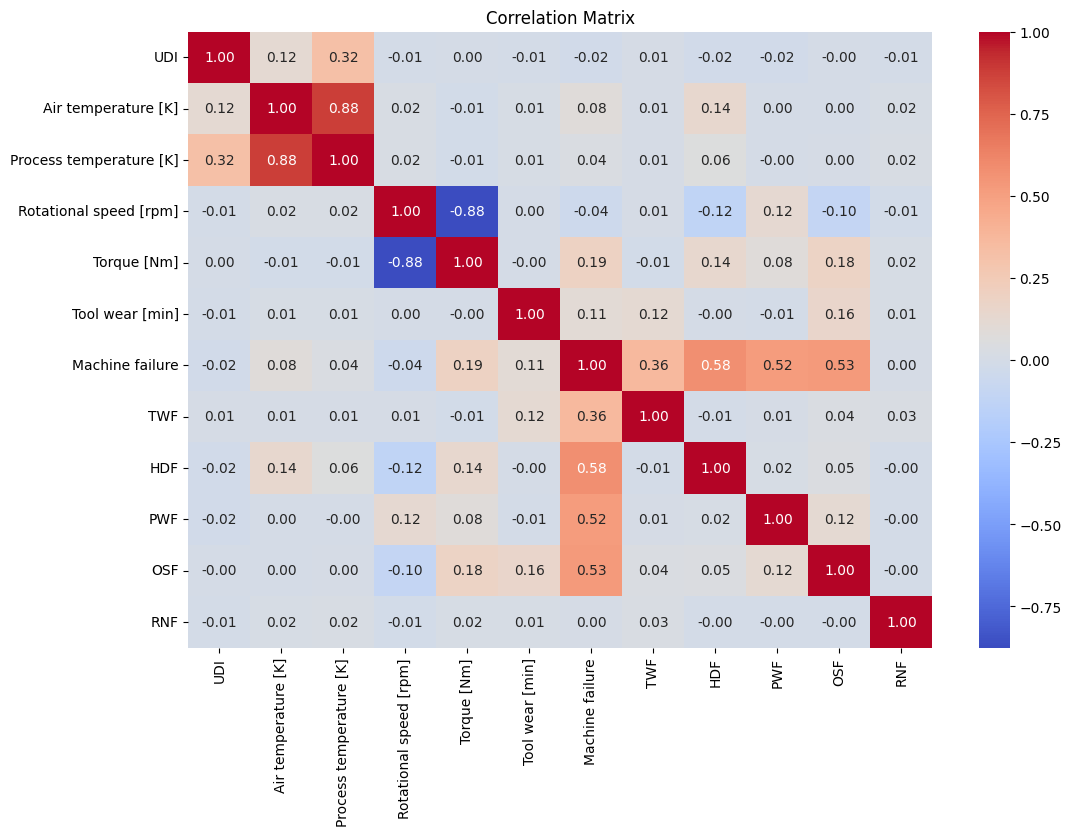

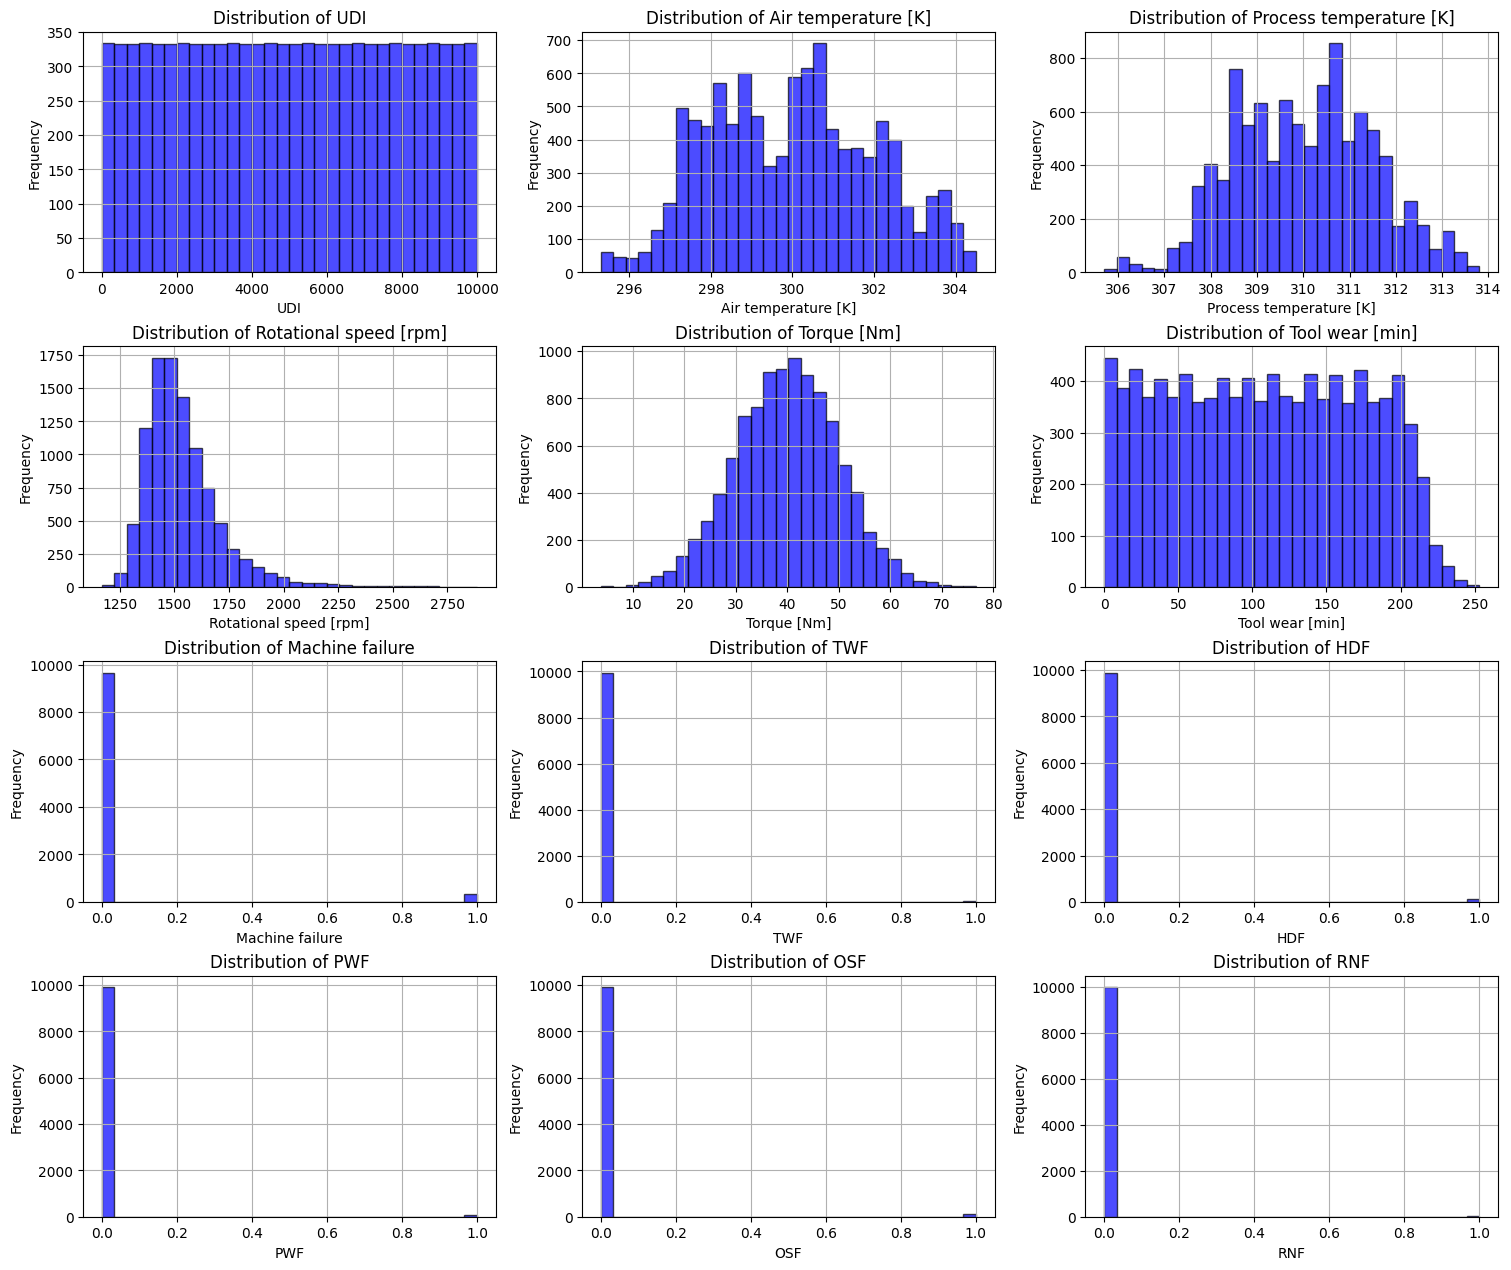

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import FunctionTransformer #for normalization
from sklearn.pipeline import Pipeline #for pipeline creation
#from sklearn.base import BaseEstimator, TransformerMixin #for the data visualisation custom transformer
from sklearn.impute import SimpleImputer #for missing value imputation 

data = pd.read_csv('./data/ai4i2020.csv')
pd.set_option('expand_frame_repr', False)

class DataVisualiser():
    def __init__(self):
        pass

    def data_overview(data):
        def print_data_overview(data):
            print("Data Overview:")
            print(data.head())
            print("\nData Information:")
            print(data.info())
            print("\nData Description:")
            print(data.describe())

        def print_missing_values(data):
            print("\nMissing Values:")
            missing_values = data.isnull().sum()
            print(missing_values[missing_values > 0])

        def print_column_types(data):
            print("\nColumn Types:")
            column_types = data.dtypes
            print(column_types)

        def print_unique_values(data):
            print("\nUnique Values:")
            unique_values = data.nunique()
            print(unique_values)

        def print_correlation_matrix(data):
            print("\nCorrelation Matrix:")
            correlation_matrix = data.corr(numeric_only = True)
            print(correlation_matrix)
            plt.figure(figsize=(12, 8))
            sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
            plt.title("Correlation Matrix")
            plt.show()

        def plot_columns(data):
            #define columns to plot
            columns_to_plot = data.select_dtypes(include=[np.number]).columns.tolist()

            #number of plots per row
            n_cols = 3
            n_rows = int((len(data.columns)-(data.dtypes == 'object').sum())/n_cols) + 1

            # Create a figure with subplots for each column
            figure, axis = plt.subplots(n_rows, n_cols, figsize=(15, 15), constrained_layout=True, squeeze=False)

            # plot counter
            count=0
            for r in range(n_rows):
                for c in range(n_cols):
                    try:
                        # Get the current axis
                        ax = axis[r,c]
                        column_name = columns_to_plot[count]

                        # Set the title for the current subplot
                        ax.set_title(f'Distribution of {column_name}')
                        # Plot the histogram for the current column
                        ax.hist(data[column_name], bins=30, color='blue', alpha=0.7, edgecolor='black')
                        ax.set_xlabel(column_name)
                        ax.set_ylabel('Frequency')
                        ax.grid()
                        ax.set_title(f'Distribution of {column_name}')
                    except IndexError:
                        # If the axis is out of bounds, break the loop
                        break    
                    count+=1

            #delete empty subplots
            for i in range(count, n_rows*n_cols):
                r = int(i/n_cols)
                c = i%n_cols
                figure.delaxes(axis[r,c])
            # Adjust layout and show the plot
            #plt.tight_layout()
            plt.show()

        print_data_overview(data)
        print_missing_values(data)
        print_column_types(data)
        print_unique_values(data)
        print_correlation_matrix(data)
        plot_columns(data)

def drop_columns(data):
    correlated_columns_to_keep = ['TWF', 'HDF', 'PWF', 'OSF']
    non_correlated_columns = [col for col in data if col not in correlated_columns_to_keep]
    data.drop(non_correlated_columns, axis=1, inplace=True)
    return data
    


#drop unnecessary columns
#data.drop(columns=['UDI'], inplace=True)

#print a summary of the data
#data_overview(data)
def normalize_data(df):    
    normalized_df = df.copy()
    #normalize all numeric columns
    columns_to_plot = df.select_dtypes(include=[np.number]).columns.tolist()
    for column in columns_to_plot:
        # Normalize each column of the DataFrame between 0 and 1
        min_value = normalized_df[column].min()
        max_value = normalized_df[column].max()
        if min_value == max_value:
            # If all values are the same, set to that value
            normalized_df[column] = min_value
        else:
            normalized_df[column] = (normalized_df[column] - min_value) / (max_value - min_value)
    return normalized_df

# Define the pipeline
def create_pipeline():
    return Pipeline([
        ('normalize', FunctionTransformer(normalize_data, validate=False)), #1st step: normalize the data
        ('fill_missing', SimpleImputer(strategy='constant',fill_value=1)), #2nd step: fill missing values with mean
        #('visualise', CustomVisualiser()),  #2nd step: custom visualizer
        #('drop_columns', FunctionTransformer(drop_columns, validate=False)), #3rd step: drop unnecessary columns
        ('model', svm.SVC(kernel='linear'))  #4th step: SVM classifier with linear kernel
    ])


#normalized_data= normalize_transformer.transform(data)
DataVisualiser.data_overview(data)


__Observations__

It seems that this 4 features: TWF, HDF, PWF, and OSF are the ones that correlate the most with the "machine failure". As a result all the other features will be dropped for the training process. 

In [7]:
#drop the target column from the normalized data
correlated_columns_to_keep = ['TWF', 'HDF', 'PWF', 'OSF']
non_correlated_columns = [col for col in data if col not in correlated_columns_to_keep]
validation_field = 'Machine failure'

#split the data into training and testing sets 80% for training and 20% for testing
train_X, test_X, train_y, test_y = train_test_split(data.drop(non_correlated_columns, axis=1), data[validation_field], test_size=0.8, random_state=42)

# Print the size and shapes of the training and testing sets
print(f"Training set size: {train_X.shape[0]}. Training set shape: {train_X.shape}" )
print(f"Testing set size: {test_X.shape[0]}. Testing set shape: {test_X.shape}")


Training set size: 2000. Training set shape: (2000, 4)
Testing set size: 8000. Testing set shape: (8000, 4)


Test set accuracy: 0.99925

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      1.00      1.00      7736
     Failure       1.00      0.98      0.99       264

    accuracy                           1.00      8000
   macro avg       1.00      0.99      0.99      8000
weighted avg       1.00      1.00      1.00      8000



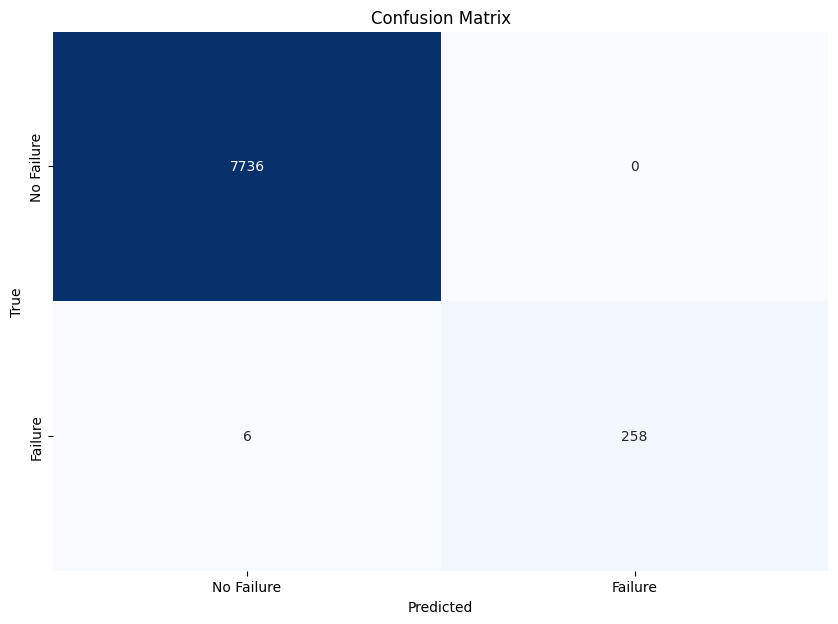

In [8]:
# Create a pipeline with normalization, visualisation and SVM classifier
pipeline = create_pipeline()

# Train the pipeline on the training set    
pipeline.fit(train_X, train_y)




# Use the trained pipeline to predict the test set
def test_and_analyse_model(test_X, test_y):
    pred = pipeline.predict(test_X)
    # Print the accuracy score
    test_accuracy_score = accuracy_score(test_y, pred) #use the "sklearn.metric.accuracy_score"
    print(f"Test set accuracy: {test_accuracy_score}")
    print("\nClassification Report:")
    print(classification_report(test_y, pred, target_names=['No Failure', 'Failure']))
    # Print the confusion matrix
    cm = confusion_matrix(test_y, pred) #create the confusion matrix
    plt.figure(figsize=(10,7))
    plt.title('Confusion matrix')
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()    


test_and_analyse_model(test_X, test_y)

Now that the model has been sucessefully trained it can be used in a production environment. For this you don't want to train it again. 

The approach taken is to:
- serialise it for later use
- Create a way to call the serialised model:
    - via python command line; or
    - via API using flask or other framework you may be knowlegeable; or
    - via API using a docker container; or
    - via API using a docker container hosted in a Kubernetes cluster (Azure container ACI will work too); or
    - any other way one feels more appropriate  

In [4]:
#I'm going to serialize the model using dill
import dill
# Save the model to a file
with open('./model/svm_model.dill', 'wb') as file:
    # Use dill to serialize the pipeline object
    dill.dump(pipeline, file)

In [5]:
#test the model
# Load the model from the file
with open('./model/svm_model.dill', 'rb') as file:
    loaded_model = dill.load(file)
# Predict using the loaded model
pred = loaded_model.predict(test_X)
# Print the accuracy score
test_accuracy_score = accuracy_score(test_y, pred) #use the "sklearn.metric.accuracy_score"
print(f"Test set accuracy: {test_accuracy_score}")

Test set accuracy: 0.99925
